In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import re
import os
import datetime

# Hint

The data across first men's team, women's team, all academy

# Objectivo
1. Which player belongs to which team
   - Anyone has been promoted from youth to senoir team? Or back to the reserve team? Compare the physical profile when he was in youth to the first team?
   - Anyone's position has been changed during the last 2 season?
2. Periodization of training
   - Daily report by team
3. Injury
   - Any player disappeared and back after high load?
   - How did the player rehab?

In [50]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000

In [51]:
df = pd.read_csv("./data/anonymous.csv")

In [52]:
# transfer km/h to m/s for max velocity
df["maximum_velocity_km_h"] = df["maximum_velocity_km_h"]/3.6


In [53]:
# Rename columns for reporting purpose
df.columns = ['Date', 'Player', 'Position', 'Team Name', 'Duration',
       'Total Distance(m)', 'Total Player Load', 'Acc 2m/s2 Total Effort',
       'Acc 3m/s2 Total Effort', 'Dec 2m/s2 Total Effort',
       'Dec 3m/s2 Total Effort', 'High Intensity Distance(m)',
       'Sprint Distance(m)', 'Maximum Velocity(m/s)', 'IMA COD(left)',
       'IMA COD(right)']

In [54]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [55]:
# Function to determine the season
def get_season(date):
    for season, (start_date, end_date) in seasons.items():
        if start_date <= date.strftime('%Y-%m-%d') <= end_date:
            return season
    return None


In [56]:
seasons = {
    "2021/22": ('2021-07-01', '2022-06-30'),
    "2022/23": ('2022-07-01', '2023-06-30')
}

In [57]:
# Apply the function to create the 'Season' column
df['Season'] = df['Date'].apply(get_season)

In [58]:
df.head()

,Date,Player,Position,Team Name,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right),Season
0,2021-07-01,Player1,Central Midfielder,Team1,102,5162.0,491.0,3,0,7,2,96.7,0.0,7.138889,50,39,2021/22
1,2021-07-01,Player2,Central Midfielder,Team1,190,4932.9,561.4,14,1,12,3,170.0,0.0,6.944444,43,42,2021/22
2,2021-07-06,Player3,Winger,Team2,66,5628.6,626.4,18,2,11,1,223.8,39.1,8.333333,33,23,2021/22
3,2021-07-06,Player4,Central Midfielder,Team3,55,6239.1,624.9,18,1,9,7,332.4,12.2,8.138889,17,18,2021/22
4,2021-07-06,Player5,Attacker,Team3,55,5440.4,507.1,22,3,14,8,299.6,6.1,8.111111,19,40,2021/22


---

In [59]:
# Define season
date_ranges = {
    "2021/22": ('2021-07-01', '2022-06-30'),
    "2022/23": ('2022-07-01', '2023-06-30'),
    "Overall": ('2021-07-01', '2023-06-30')
}

In [60]:
squads = df.groupby("Team Name")["Player"].apply(set).to_dict()

In [61]:
len(df["Player"].unique())

225

In [62]:
for key, value in squads.items():
    print(key, len(value))

Team1 91
Team2 45
Team3 41
Team4 23
Team5 61
Team6 39
Team7 43
Team8 7


- Parameter Definition: https://support.catapultsports.com/hc/en-us/articles/360001935876-Vector-Smartwatch-App-Parameters-Definitions. 
- What is IMA: https://support.catapultsports.com/hc/en-us/articles/360000510856-What-is-IMA
- ima_cod_left/right: Inertial Movement Analysis - Change of Direction

In [63]:
def create_sankey(df, date_range, column_name, node_positions=None):
    # Filter DataFrame for the given date range
    start_date, end_date = date_range
    df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    # Create a list of unique values in the specified column
    nodes = df_filtered[column_name].unique().tolist()
    
    # Initialize the Sankey diagram components
    node_labels = nodes
    links = {'source': [], 'target': [], 'value': []}
    
    # Create the links for the Sankey diagram
    previous_value = {}

    for date, group in df_filtered.groupby('Date'):
        current_value = group.set_index('Player')[column_name].to_dict()

        if previous_value:
            for player, value in current_value.items():
                if player in previous_value and previous_value[player] != value:
                    source_idx = nodes.index(previous_value[player])
                    target_idx = nodes.index(value)
                    links['source'].append(source_idx)
                    links['target'].append(target_idx)
                    links['value'].append(1)

        previous_value = current_value

    # Extract positions for each node, setting default None for unspecified positions
    node_x = [node_positions[value][0] if node_positions and value in node_positions else None for value in node_labels]
    node_y = [node_positions[value][1] if node_positions and value in node_positions else None for value in node_labels]

    # Create the Sankey diagram with specified node positions
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=30,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=node_labels,
            x=node_x,
            y=node_y
        ),
        link=dict(
            source=links['source'],
            target=links['target'],
            value=links['value']
        )
    ))

    fig.update_layout(title_text=f"Player Movements Between {column_name}s ({start_date} to {end_date})", font_size=10)
    return fig

In [64]:
# Specify node positions for specific teams (Team2 and Team4 in this example)
node_positions = {
    'Team1': (None, None),
    'Team2': (None, None),  
    'Team3': (0, 0),
    'Team4': (None, None),
    'Team5': (None, None),
    'Team6': (None, None),
    'Team7': (0.95, 0.8),
    'Team8': (0.7, 0.9),
}

In [65]:
# Create Sankey diagrams for each date range using 'Team Name'
for title, date_range in date_ranges.items():
    fig = create_sankey(df, date_range, 'Team Name', node_positions)
    fig.show()

- Men's team:
Team 1, 2, 3, 4, 5, 6?
- Women's team:
Team 7, 8?

In [66]:
# Create a list of unique positions
positions = df['Position'].unique().tolist()

# Initialize the Sankey diagram components
node_labels = positions
links = {'source': [], 'target': [], 'value': []}

# Create the links for the Sankey diagram
previous_position = {}

for date, group in df.groupby('Date'):
    current_position = group.set_index('Player')['Position'].to_dict()
    
    if previous_position:
        for player, position in current_position.items():
            if player in previous_position and previous_position[player] != position:
                source_idx = positions.index(previous_position[player])
                target_idx = positions.index(position)
                links['source'].append(source_idx)
                links['target'].append(target_idx)
                links['value'].append(1)
    
    previous_position = current_position

# Specify node positions for specific positions (Position2 and Position4 in this example)
node_positions = {
    'Position1': (None, None),
    'Position2': (0.3, 0.9),  # Specific position for Position2
    'Position3': (None, None),
    'Position4': (0.7, 0.1)   # Specific position for Position4
}

# Extract positions for each node, setting default None for unspecified positions
node_x = [node_positions[position][0] if position in node_positions else None for position in node_labels]
node_y = [node_positions[position][1] if position in node_positions else None for position in node_labels]

# Create the Sankey diagram with specified node positions
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        x=node_x,
        y=node_y
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value']
    )
))

fig.update_layout(title_text="Player Movements Between Positions Over Time", font_size=10)
fig.show()

# Metrics Explore

In [67]:
df.head()

,Date,Player,Position,Team Name,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right),Season
0,2021-07-01,Player1,Central Midfielder,Team1,102,5162.0,491.0,3,0,7,2,96.7,0.0,7.138889,50,39,2021/22
1,2021-07-01,Player2,Central Midfielder,Team1,190,4932.9,561.4,14,1,12,3,170.0,0.0,6.944444,43,42,2021/22
2,2021-07-06,Player3,Winger,Team2,66,5628.6,626.4,18,2,11,1,223.8,39.1,8.333333,33,23,2021/22
3,2021-07-06,Player4,Central Midfielder,Team3,55,6239.1,624.9,18,1,9,7,332.4,12.2,8.138889,17,18,2021/22
4,2021-07-06,Player5,Attacker,Team3,55,5440.4,507.1,22,3,14,8,299.6,6.1,8.111111,19,40,2021/22


In [68]:
# List of metrics to plot
metrics = ['Duration', 'Total Distance(m)', 'Total Player Load', 'Acc 2m/s2 Total Effort',
           'Acc 3m/s2 Total Effort', 'Dec 2m/s2 Total Effort', 'Dec 3m/s2 Total Effort',
           'High Intensity Distance(m)', 'Sprint Distance(m)', 'Maximum Velocity(m/s)',
           'IMA COD(left)', 'IMA COD(right)']


<Axes: >

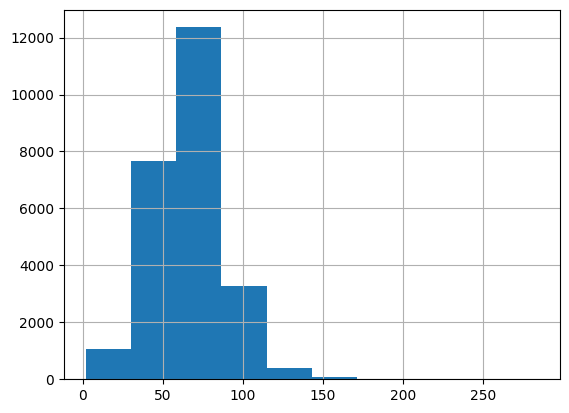

In [69]:
df["Duration"].hist()

<Axes: >

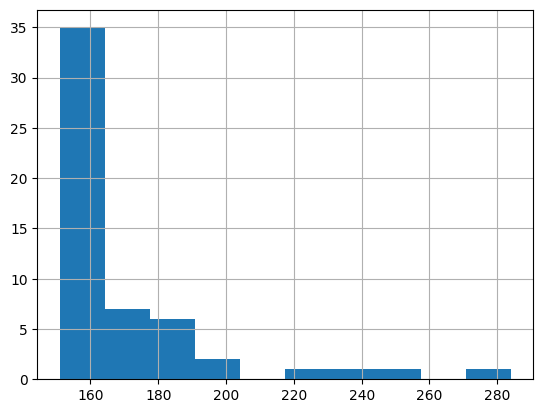

In [70]:
df[df["Duration"]>150]["Duration"].hist()

In [71]:
unique_combinations = df[['Player', 'Position', 'Team Name']].drop_duplicates()

In [72]:
date_range = pd.date_range(start='2021-07-01', end='2023-06-30')

In [73]:
# Create a complete date range for each combination
complete_data = pd.DataFrame()

for _, row in unique_combinations.iterrows():
    player, position, team_name = row
    temp_df = pd.DataFrame({'Date': date_range})
    temp_df['Player'] = player
    temp_df['Position'] = position
    temp_df['Team Name'] = team_name
    complete_data = pd.concat([complete_data, temp_df], ignore_index=True)

In [74]:
merged_df = pd.merge(complete_data, df, on=['Date', 'Player', 'Position', 'Team Name'], how='left')

In [75]:
for column in metrics:
    merged_df[column] = merged_df[column].astype(float) 

In [76]:
merged_df = merged_df.sort_values(by='Date')

In [77]:
merged_df.head()

,Date,Player,Position,Team Name,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right),Season
0,2021-07-01,Player1,Central Midfielder,Team1,102.0,5162.0,491.0,3.0,0.0,7.0,2.0,96.7,0.0,7.138889,50.0,39.0,2021/22
180310,2021-07-01,Player73,Goal Keeper,Team2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81760,2021-07-01,Player96,Winger,Team3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48910,2021-07-01,Player68,Attacker,Team1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213160,2021-07-01,Player194,Central Midfielder,Team4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
training_count = df.drop_duplicates()["Player"].value_counts().reset_index()

In [79]:
training_count.head()

,Player,count
0,Player9,407
1,Player14,401
2,Player34,388
3,Player7,386
4,Player36,376


In [80]:
training_count

,Player,count
0,Player9,407
1,Player14,401
2,Player34,388
3,Player7,386
4,Player36,376
5,Player3,375
6,Player18,375
7,Player66,373
8,Player16,363
9,Player94,361


In [81]:
df.groupby(["Team Name","Position"])[metrics].mean()

Duration  Total Distance(m)  Total Player Load  Acc 2m/s2 Total Effort  Acc 3m/s2 Total Effort  Dec 2m/s2 Total Effort  Dec 3m/s2 Total Effort  High Intensity Distance(m)  Sprint Distance(m)  Maximum Velocity(m/s)  IMA COD(left)  IMA COD(right)
Team Name Position                                                                                                                                                                                                                                                                 
Team1     Attacker            62.477354        5007.744279         532.472646               16.342670                1.956496               14.951132                4.363528                  194.370381           13.065733               7.415872      28.265793       31.262813
          Central Midfielder  64.687937        5339.423754         609.198184               14.333954                1.356311               14.594318                4.301816                  173.984397           16.180624               7.157028      27.568235       29.281323
          Centre Back         64.724359        5110.960769         559.869936               15.442308                1.882051               13.864103                4.287179                  167.681154           13.785192               7.333440      25.369231       28.896154
          Full Back           65.215733        5292.792253         612.222527               18.624553                2.535161               16.433850                5.646007                  247.692610           15.016329               7.565985      28.053635       29.601907
          Goal Keeper         84.916324        4252.332236         459.323594                7.150892                0.781893                5.381344                1.746228                   11.232510            0.657750               5.527511      40.377229       41.968450
          Winger              62.774101        4998.886403         574.946115               20.843165                4.410791               15.171223                5.384892                  256.215827           20.578129               7.636771      26.871223       31.328058
Team2     Attacker            63.121689        5084.503725         576.125993               18.459437                2.659768               15.884934                5.246689                  210.499007           11.323262               7.461806      28.738411       30.603477
          Central Midfielder  63.561064        5329.421705         586.625635               14.315599                1.730955               13.686820                3.883313                  171.815175           19.072491               7.150275      27.232769       30.884522
          Centre Back         64.531365        5135.261328         552.244133               15.540221                1.850923               13.663469                4.095203                  177.495351            8.975646               7.334420      22.898155       26.675277
          Full Back           62.930398        5004.684517         573.147869               17.669034                2.559659               13.776989                4.198864                  211.167472           13.832244               7.343553      22.437500       29.089489
          Goal Keeper         74.588699        3365.953351         382.204336                6.180026                0.561104                4.657030                1.229961                    7.718791            0.422865               5.513250      33.930355       34.935611
          Winger              61.883758        5152.244506         554.096497               19.131369                3.053344               13.937898                3.988854                  217.544666           28.553344               7.452163      22.705414       26.560510
Team3     Attacker            63.465969        4945.151309         552.371728               17.376963                1.701571               14.256545                4.

In [89]:
df['Weekday'] = df['Date'].dt.day_name()

In [91]:
df.groupby("Weekday")[metrics].mean()

,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right)
Weekday,,,,,,,,,,,,
Friday,62.430130,4491.088944,510.830629,13.738553,1.765836,11.749941,3.322420,134.974875,9.108944,6.928331,27.404270,30.586951
Monday,59.743869,4444.189996,511.311989,14.127287,1.426625,11.627092,3.370961,123.629895,8.497392,6.778037,27.531335,30.593227
Saturday,68.139708,6317.470488,663.006917,16.040231,1.859465,16.030311,5.346652,278.364067,27.828906,7.535294,26.055663,29.289887
Sunday,63.980092,5520.433002,590.599923,14.324655,1.583461,14.249617,4.421133,211.329326,24.196095,7.350987,24.807044,27.830015
Thursday,66.060832,4721.503483,552.709566,15.083446,2.138399,12.795568,3.240163,134.508684,13.411895,7.142350,29.561058,33.302578
Tuesday,71.193133,5355.874485,615.889678,17.032833,2.094850,14.580043,4.036052,159.611845,14.332167,7.171561,33.182189,37.022103
Wednesday,69.050186,5249.003876,598.426360,16.120000,2.012174,14.124472,3.934658,169.821888,12.877863,7.157854,30.187081,33.863106


In [92]:
def calc_ewma_acwr(df, metric, acute_days=7, chronic_days=28):
    # The ACWR is the ratio between how much workload has been done 
    # in the last 7 days (acute workload) versus 
    # the average weekly workload that has been performed 
    # over the previous 28 days (chronic workload).
    # Calculated by Exponentially Weighted Moving Average
    # https://www.gpexe.com/2020/09/04/acutechronic-workload-ratio-part-2/
    
    # Function to calculate EWMA
    def ewma(series, span):
        return series.ewm(span=span, adjust=False).mean()

    # Calculate EWMA ACWR for each player
    df[f'{metric} Acute EWMA'] = df.groupby('Player')[metric].transform(lambda x: ewma(x, acute_days))
    df[f'{metric} Chronic EWMA'] = df.groupby('Player')[metric].transform(lambda x: ewma(x, chronic_days))
    df[f'{metric} EWMA ACWR'] = df[f'{metric} Acute EWMA']/df[f'{metric} Chronic EWMA']

    return df

In [94]:
acute_days=7
chronic_days=28

In [102]:
metric = "Total Player Load"

In [104]:
def ewma(series, span):
    return series.ewm(span=span, adjust=False).mean()


In [82]:
def plot_distribution(df, metric):
    g = sns.FacetGrid(df, col="Team Name", row="Season", margin_titles=True, sharex=False, sharey=False)
    g.map_dataframe(sns.histplot, x=metric, kde=True, bins=10)
    
    # for ax in g.axes.flat:
    #     if ax.get_title():
    #         title_text = ax.get_title().split(' = ')
    #         team = title_text[1]
    #         season = title_text[0]
    #         print(team, season)
    #         data_sub = df[(df['Team Name'] == team) & (df['Season'] == season)][metric]
    #         if not data_sub.empty:
    #             mean_val = data_sub.mean()
    #             median_val = data_sub.median()
    #             q25, q75 = data_sub.quantile([0.25, 0.75])
    #             std_val = data_sub.std()
    #             ax.annotate(f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\n25%: {q25:.2f}\n75%: {q75:.2f}\nStd: {std_val:.2f}',
    #                         xy=(0.95, 0.5), xycoords='axes fraction', fontsize=8, ha='right', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.subplots_adjust(top=0.9)
    g.suptitle(f'Distribution of {metric} by Team and Season')
    plt.show()

## By date and team

In [83]:
df_grouped = df.groupby(['Team Name', 'Season'])[metrics].mean().reset_index()

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




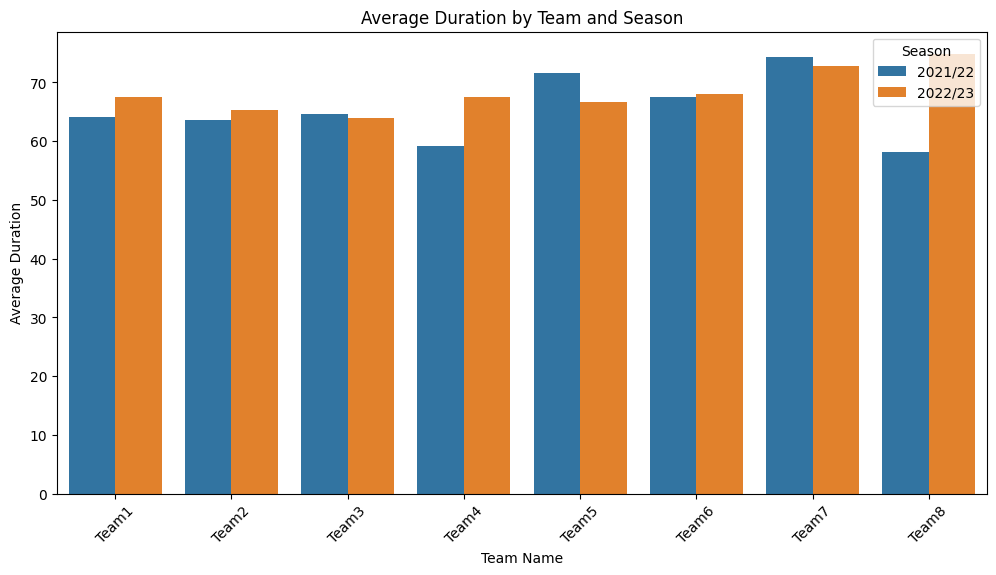

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




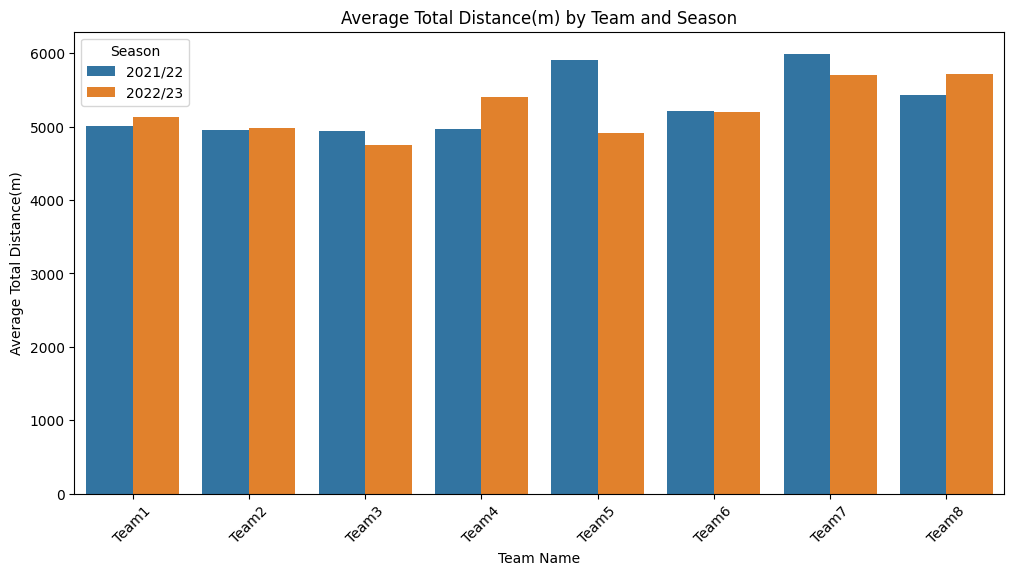

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




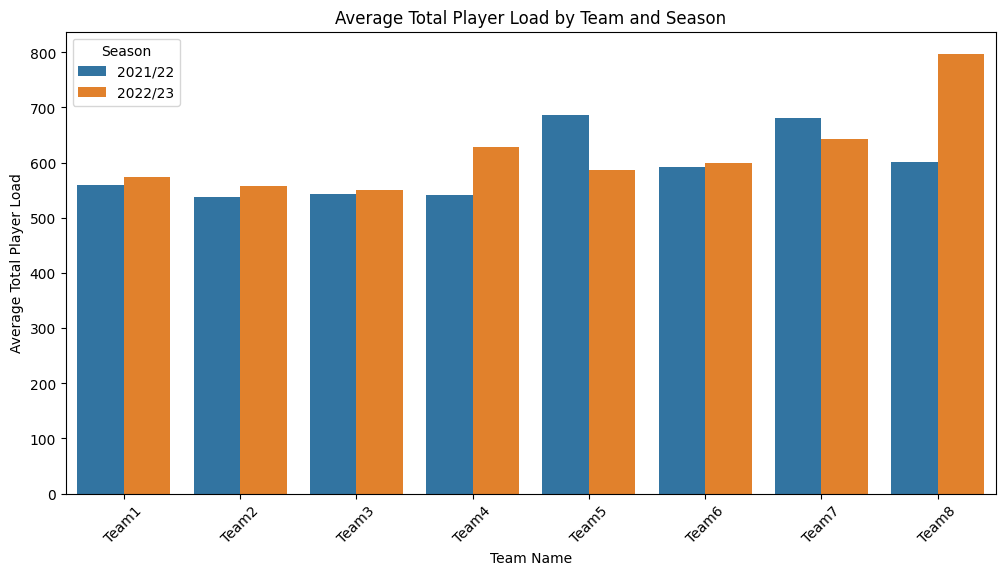

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




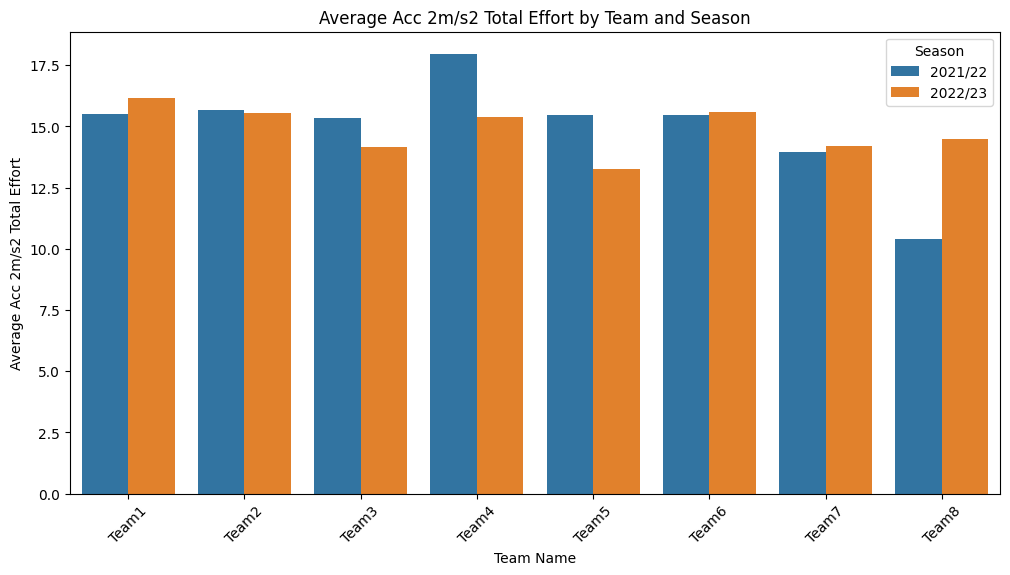

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




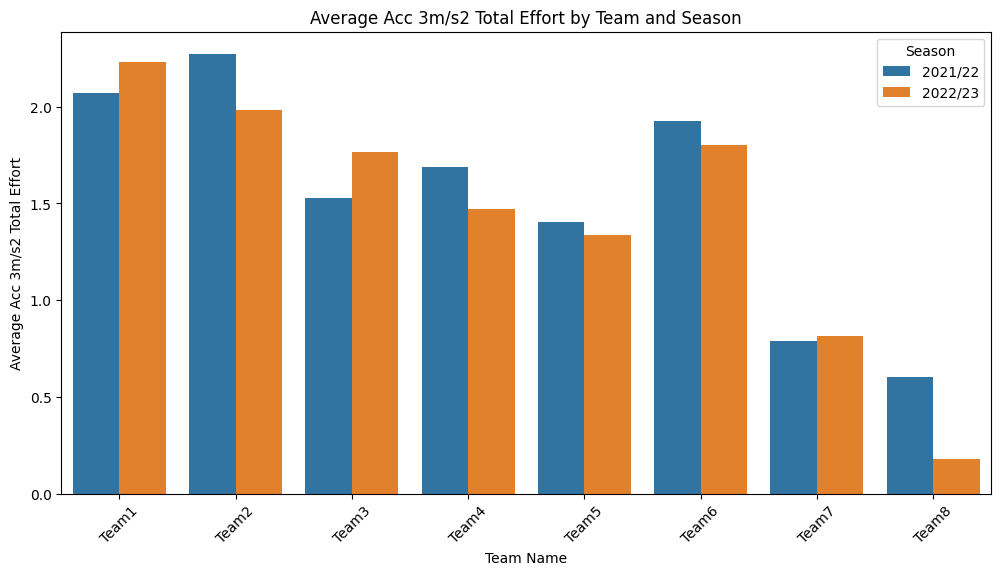

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




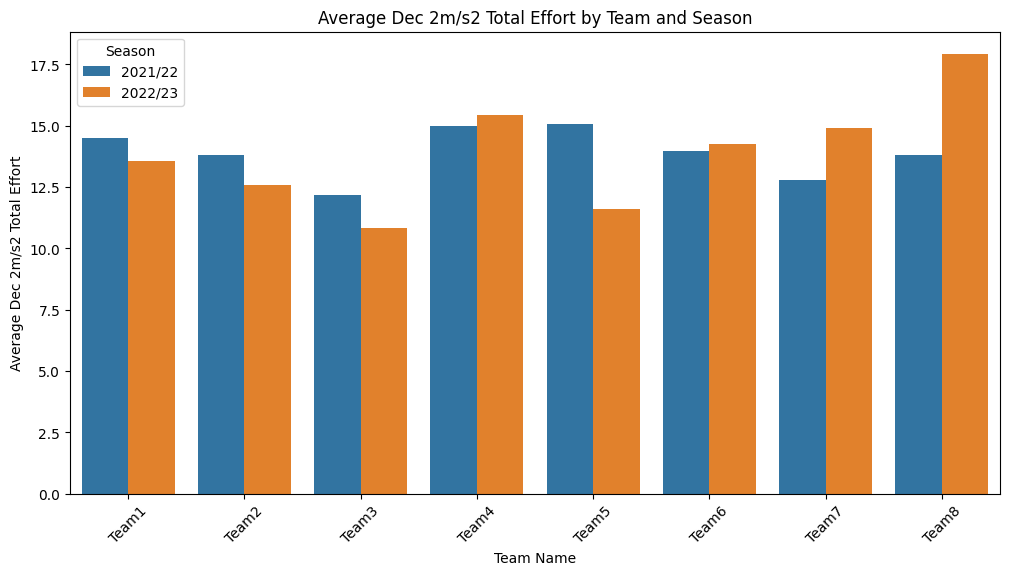

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




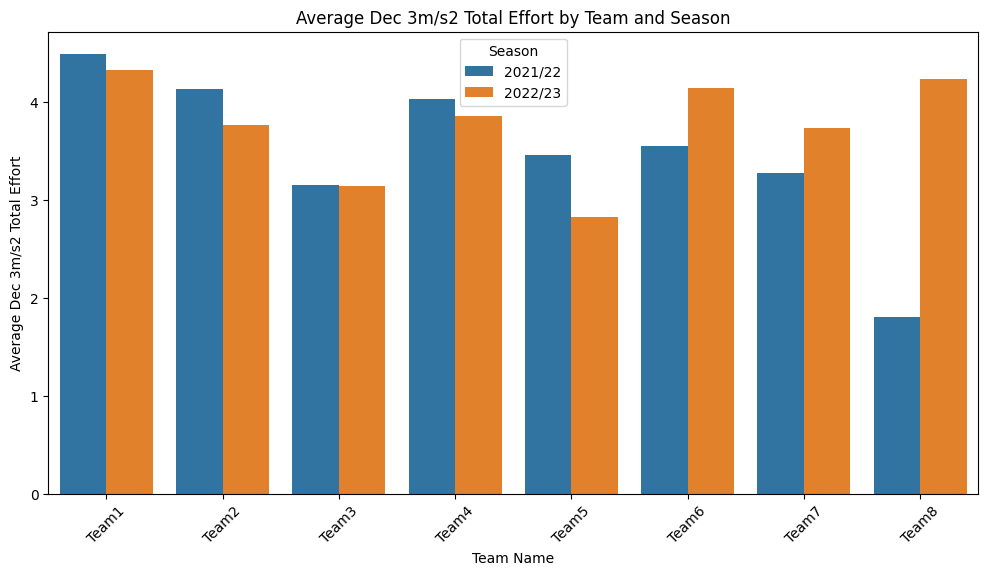

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




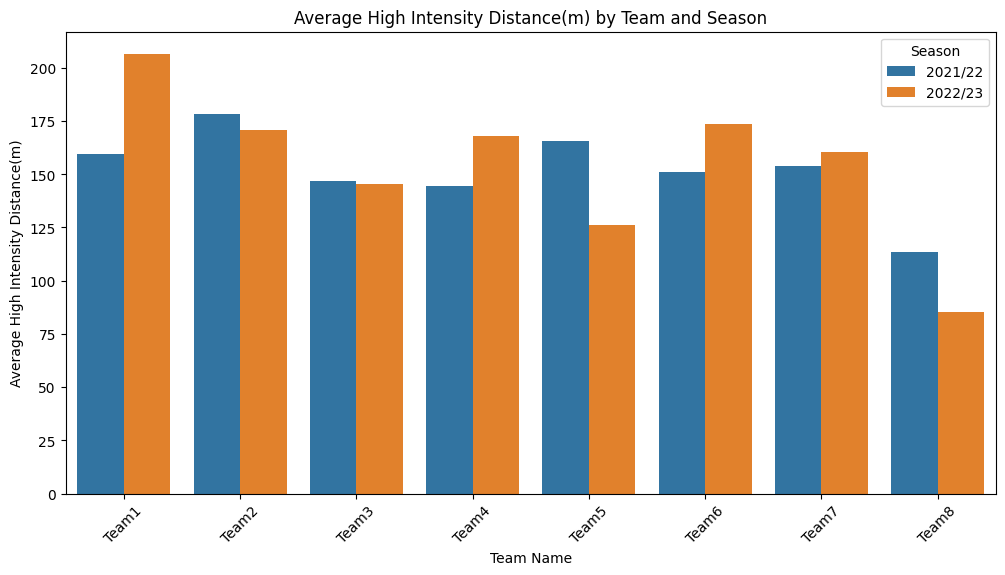

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




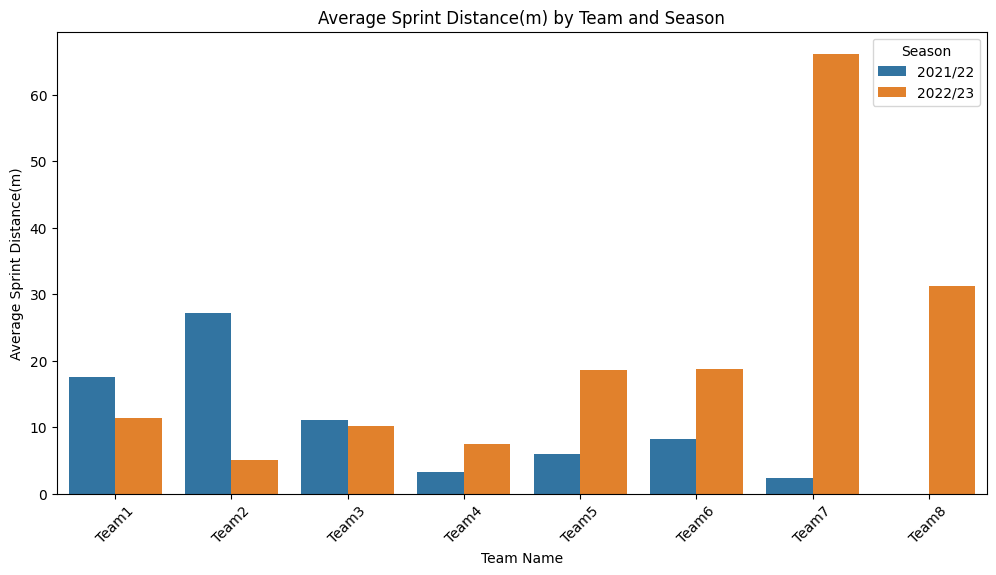

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




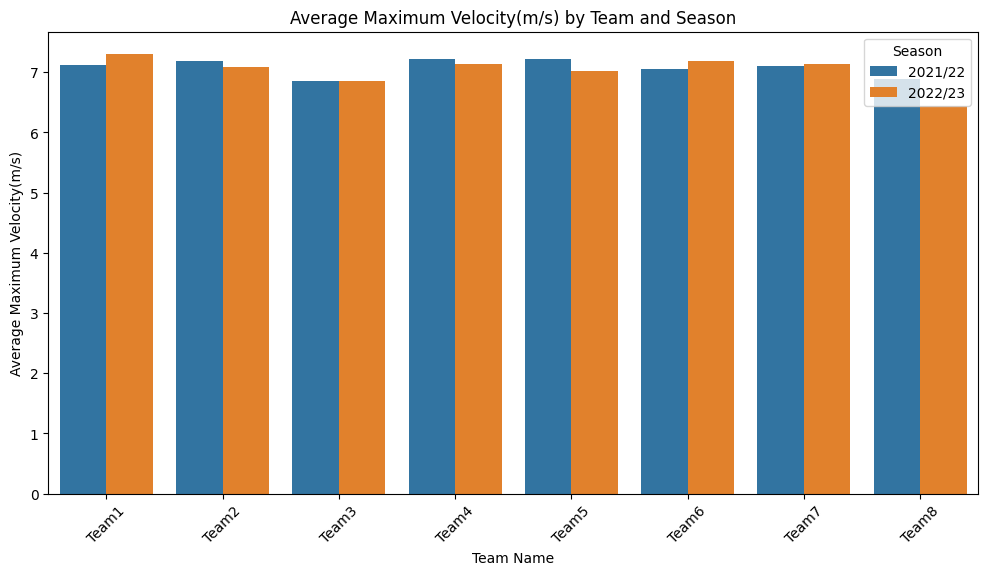

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




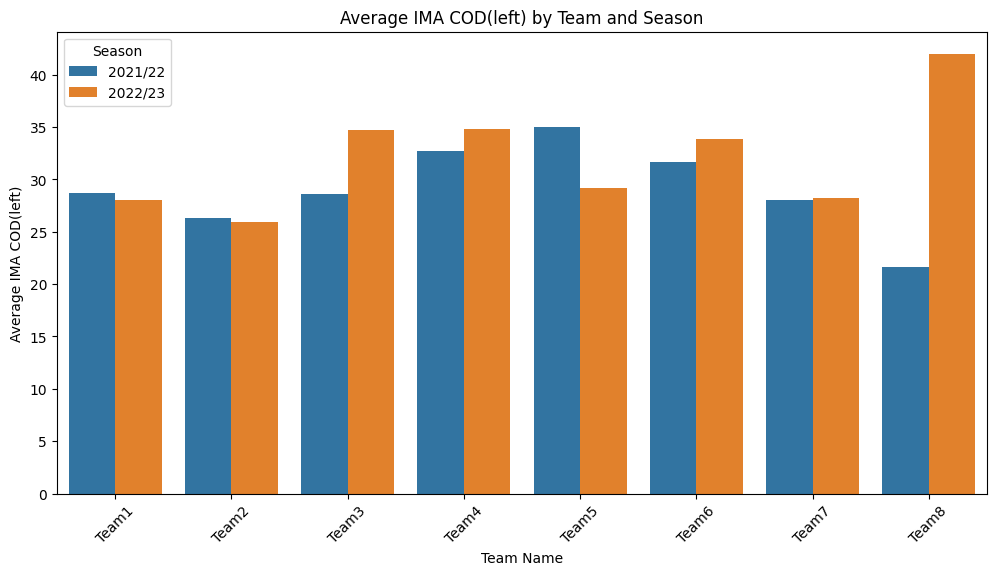

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1718911318.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




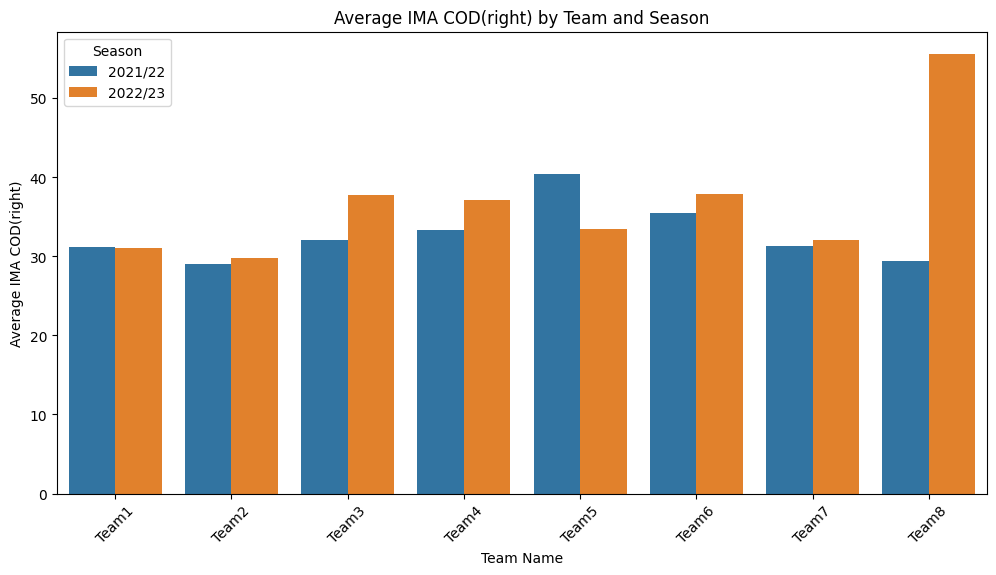

In [84]:
# Function to plot distributions
def plot_metric(df, metric):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Team Name', y=metric, hue='Season', data=df, ci=None)
    plt.title(f'Average {metric} by Team and Season')
    plt.xlabel('Team Name')
    plt.ylabel(f'Average {metric}')
    plt.legend(title='Season')
    plt.xticks(rotation=45)
    plt.show()

# Plot average for each metric
for metric in metrics:
    plot_metric(df_grouped, metric)

In [85]:
df.head()

,Date,Player,Position,Team Name,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right),Season
0,2021-07-01,Player1,Central Midfielder,Team1,102,5162.0,491.0,3,0,7,2,96.7,0.0,7.138889,50,39,2021/22
1,2021-07-01,Player2,Central Midfielder,Team1,190,4932.9,561.4,14,1,12,3,170.0,0.0,6.944444,43,42,2021/22
2,2021-07-06,Player3,Winger,Team2,66,5628.6,626.4,18,2,11,1,223.8,39.1,8.333333,33,23,2021/22
3,2021-07-06,Player4,Central Midfielder,Team3,55,6239.1,624.9,18,1,9,7,332.4,12.2,8.138889,17,18,2021/22
4,2021-07-06,Player5,Attacker,Team3,55,5440.4,507.1,22,3,14,8,299.6,6.1,8.111111,19,40,2021/22


/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




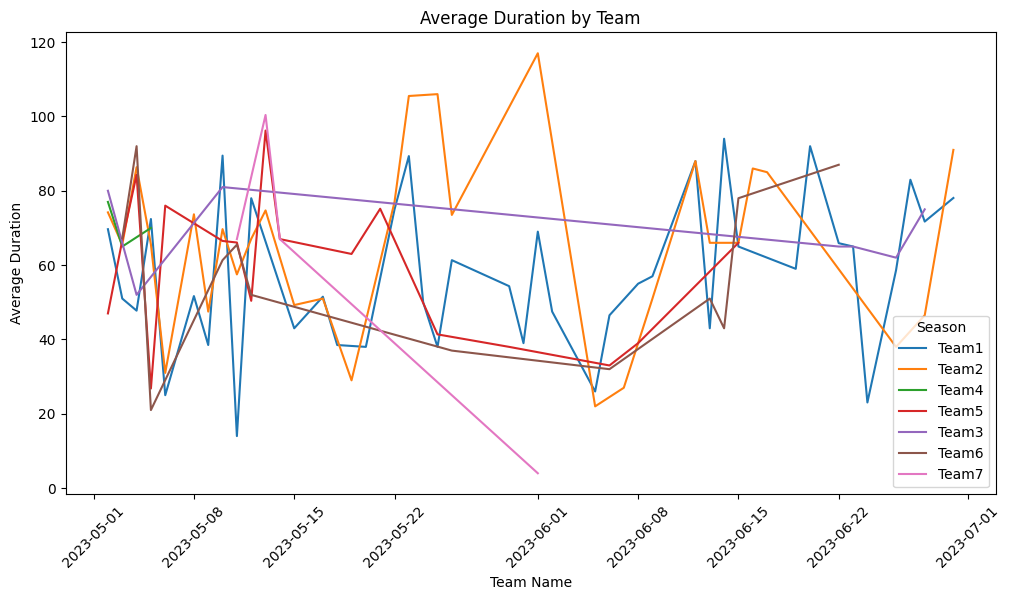

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




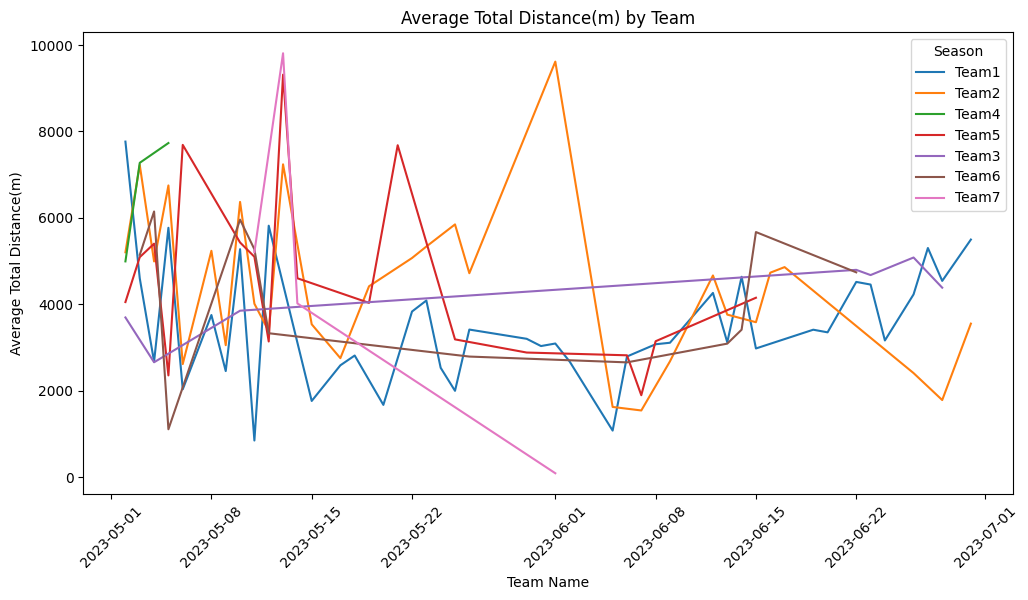

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




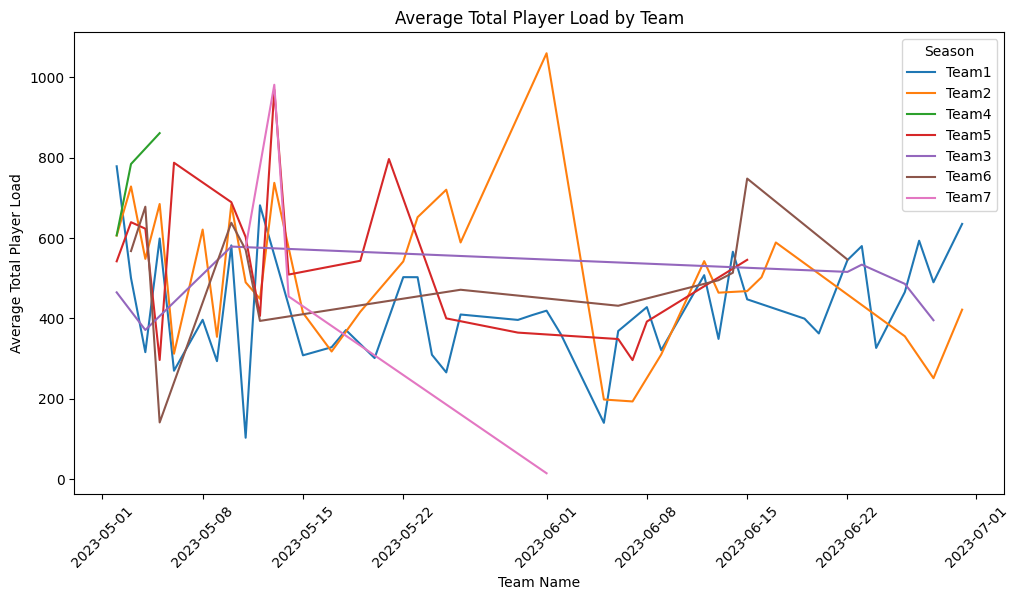

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




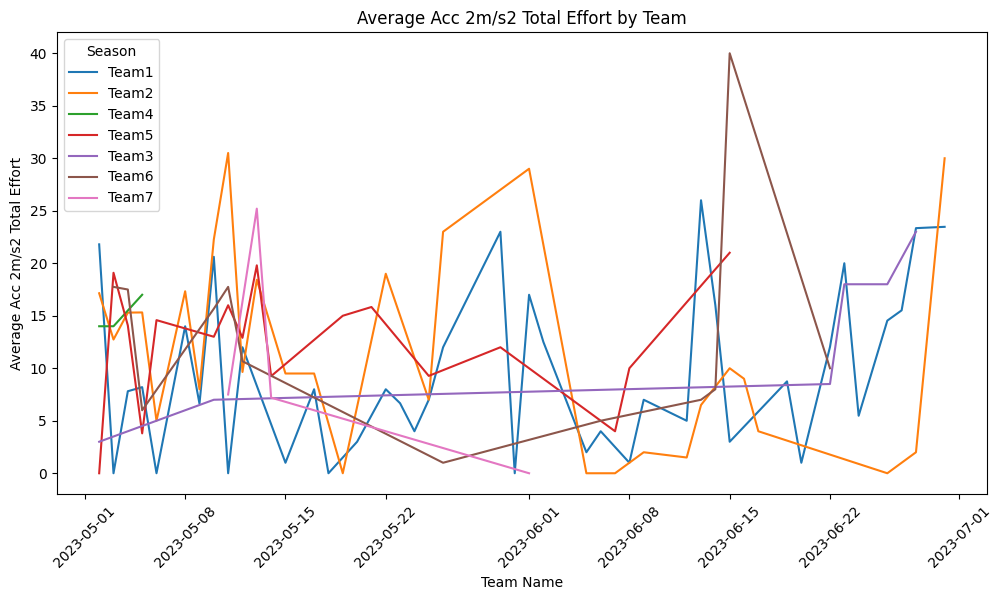

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




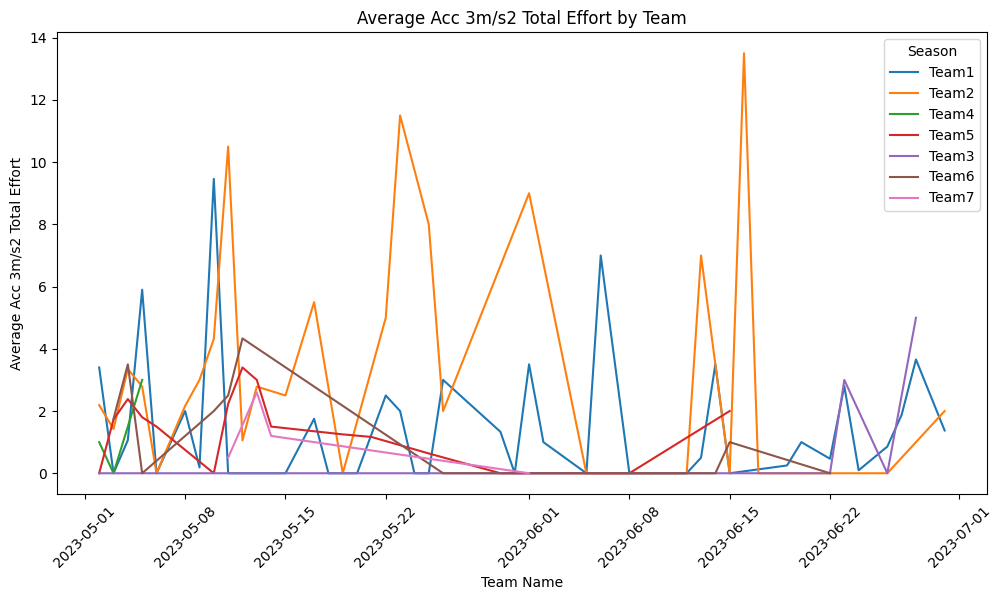

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




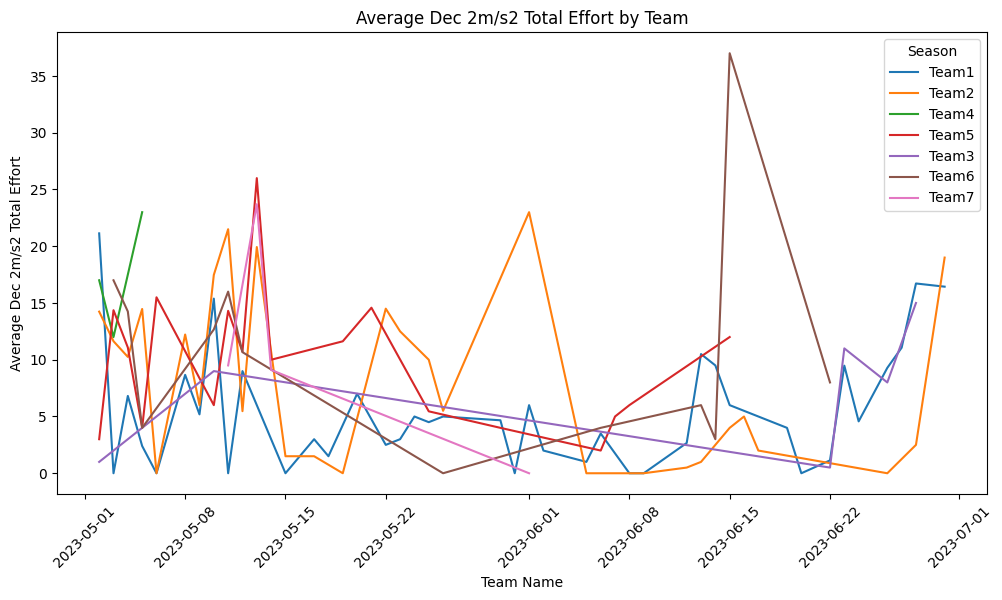

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




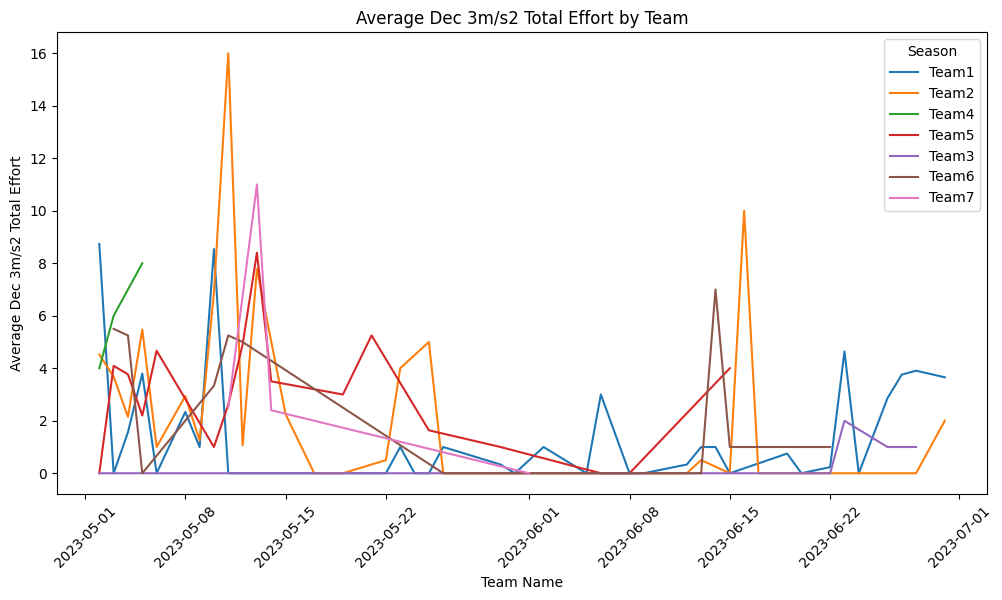

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




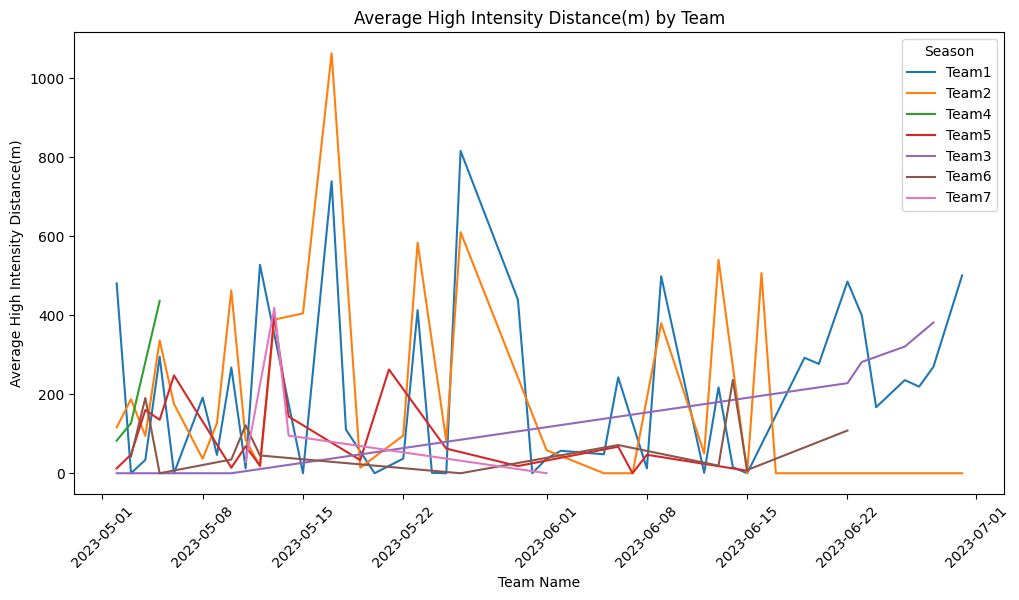

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




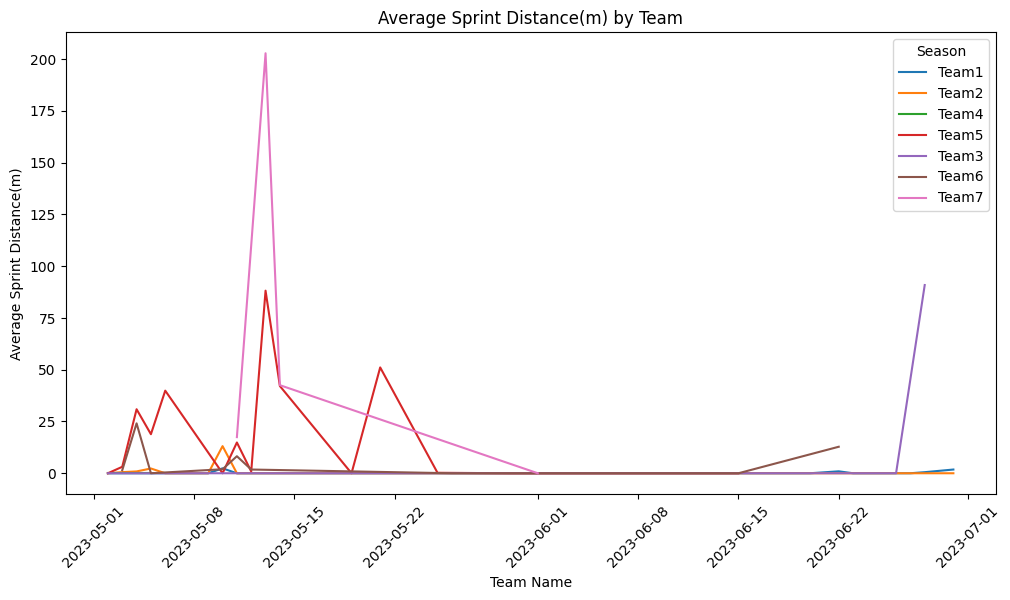

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




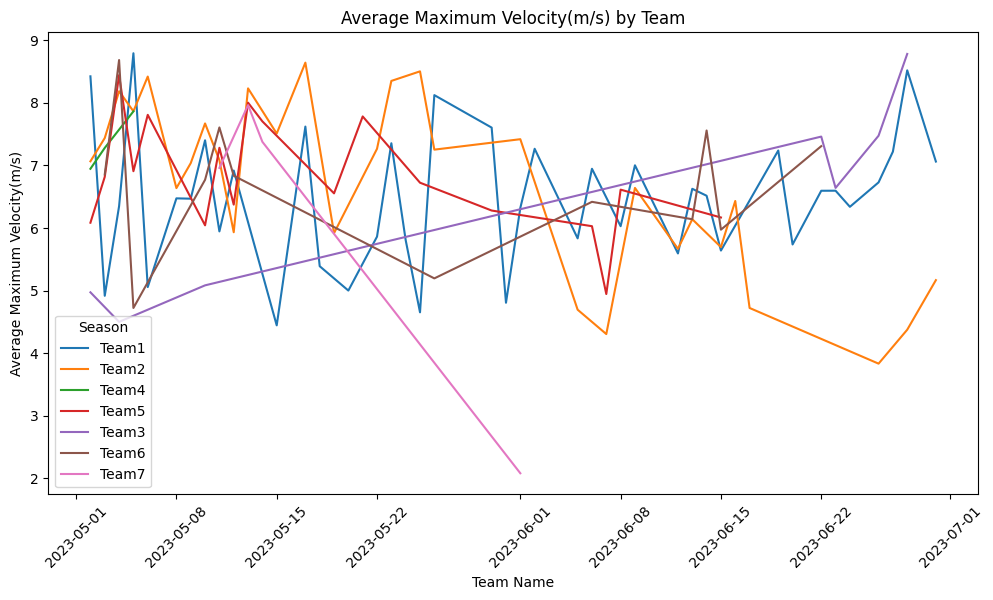

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




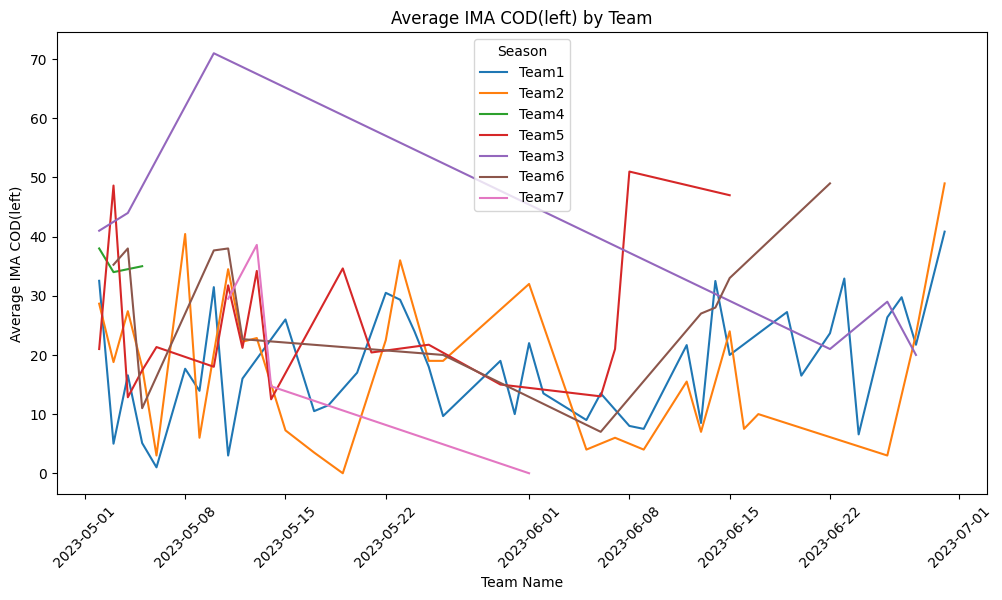

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_1606/1797951130.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




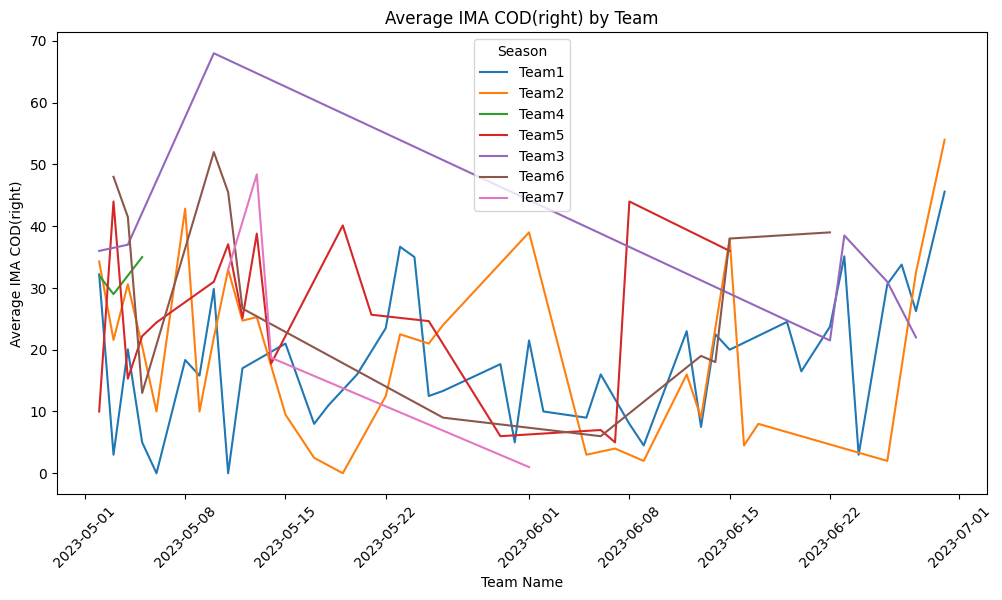

In [86]:
# Function to plot distributions
def plot_metric_by_date(df, metric):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Date', y=metric, hue="Team Name", data=df, ci=None)
    plt.title(f'Average {metric} by Team')
    plt.xlabel('Team Name')
    plt.ylabel(f'Average {metric}')
    plt.legend(title='Season')
    plt.xticks(rotation=45)
    plt.show()

# Plot average for each metric
for metric in metrics:
    plot_metric_by_date(df[df["Date"] > "2023-05-01"], metric)

## Training Frequncy and Player evolved 

In [87]:
df.head()

,Date,Player,Position,Team Name,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right),Season
0,2021-07-01,Player1,Central Midfielder,Team1,102,5162.0,491.0,3,0,7,2,96.7,0.0,7.138889,50,39,2021/22
1,2021-07-01,Player2,Central Midfielder,Team1,190,4932.9,561.4,14,1,12,3,170.0,0.0,6.944444,43,42,2021/22
2,2021-07-06,Player3,Winger,Team2,66,5628.6,626.4,18,2,11,1,223.8,39.1,8.333333,33,23,2021/22
3,2021-07-06,Player4,Central Midfielder,Team3,55,6239.1,624.9,18,1,9,7,332.4,12.2,8.138889,17,18,2021/22
4,2021-07-06,Player5,Attacker,Team3,55,5440.4,507.1,22,3,14,8,299.6,6.1,8.111111,19,40,2021/22


In [88]:
# Calculate training frequency by week
df['Week'] = df['Date'].dt.isocalendar().week
df['Year'] = df['Date'].dt.isocalendar().year

# Calculate training frequency by year and week
training_frequency = df[["Date", "Week", "Season", "Team Name"]].drop_duplicates().groupby(['Team Name', 'Year', 'Week']).size().reset_index(name='Training Frequency')

# Calculate number of players per team per training per day
players_per_training = df.groupby(['Team Name', 'Date']).size().reset_index(name='Number of Players')

# Calculate median player attendance per week per year per team
median_attendance = players_per_training.groupby(['Team Name', players_per_training['Date'].dt.isocalendar().year, players_per_training['Date'].dt.isocalendar().week])['Number of Players'].median().reset_index(name='Median Attendance')

# Rename the columns to merge properly
median_attendance.columns = ['Team Name', 'Year', 'Week', 'Median Attendance']

# Merge the median attendance into training frequency
merged_training = pd.merge(training_frequency, median_attendance, on=['Team Name', 'Year', 'Week'], how='left')



KeyError: 'Year'

In [ ]:
datetime.IsoCalendarDate(year=2022, week=52, weekday=7)

In [ ]:
merged_training.head()

,Team Name,Year,Week,Training Frequency,Median Attendance
0,Team1,2021,26,1,2.0
1,Team1,2021,27,5,22.0
2,Team1,2021,28,6,16.5
3,Team1,2021,29,6,16.0
4,Team1,2021,30,6,18.0


In [ ]:
merged_training.groupby("Team Name")[["Training Frequency", "Median Attendance"]].median()

,Training Frequency,Median Attendance
Team Name,,
Team1,6.0,16.50
Team2,6.0,14.00
Team3,4.0,1.00
Team4,3.0,1.00
Team5,5.0,8.75
Team6,5.0,8.50
Team7,3.0,4.00
Team8,1.0,1.00


- Team 1, 2 are regular team, team 3 and 4 is the rehab of team 1 and team 2?
- Team 5, 6 are other level regular team, team 7, 8 are the rehab of team 5, 6?

Very few records in Team 8, low frequency and attendance

In [ ]:
merged_training[merged_training["Team Name"] == "Team4"]

,Team Name,Year,Week,Training Frequency,Median Attendance
272,Team4,2021,27,5,4.0
273,Team4,2021,28,1,1.0
274,Team4,2021,30,1,1.0
275,Team4,2021,33,4,1.0
276,Team4,2021,35,1,1.0
277,Team4,2021,43,2,1.0
278,Team4,2021,44,1,1.0
279,Team4,2021,46,1,1.0
280,Team4,2021,48,4,1.0
281,Team4,2022,5,1,1.0


# Data processing idea:
1. To evaluate the training session intensity, calculate per minute metrics for 'Total Player Load', 'Acc 2m/s2 Total Effort',
           'Acc 3m/s2 Total Effort', 'Dec 2m/s2 Total Effort', 'Dec 3m/s2 Total Effort',
           'High Intensity Distance(m)', 'Sprint Distance(m)', 'IMA COD(left)', 'IMA COD(right)'
2. 


# start from team 8 to write some simple functions

In [ ]:
team8 = df[df["Team Name"] == "Team8"]

In [ ]:
team8.head()

,Date,Player,Position,Team Name,Duration,Total Distance(m),Total Player Load,Acc 2m/s2 Total Effort,Acc 3m/s2 Total Effort,Dec 2m/s2 Total Effort,Dec 3m/s2 Total Effort,High Intensity Distance(m),Sprint Distance(m),Maximum Velocity(m/s),IMA COD(left),IMA COD(right),Season
7168,2022-01-16,Player145,Centre Back,Team8,81,6260.8,677.0,21,0,21,3,114.1,0.0,6.944444,40,43,2021/22
9619,2022-03-16,Player157,Full Back,Team8,63,6498.2,867.6,13,3,17,3,232.1,0.0,7.222222,32,29,2021/22
9621,2022-03-16,Player158,Attacker,Team8,63,5943.4,537.7,6,0,12,0,91.9,0.0,7.111111,17,31,2021/22
9630,2022-03-16,Player121,Winger,Team8,63,5705.9,574.7,8,0,12,1,69.2,0.0,6.611111,6,23,2021/22
11863,2022-05-28,Player127,Central Midfielder,Team8,21,2720.8,347.3,4,0,7,2,60.0,0.0,6.555556,13,21,2021/22


/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




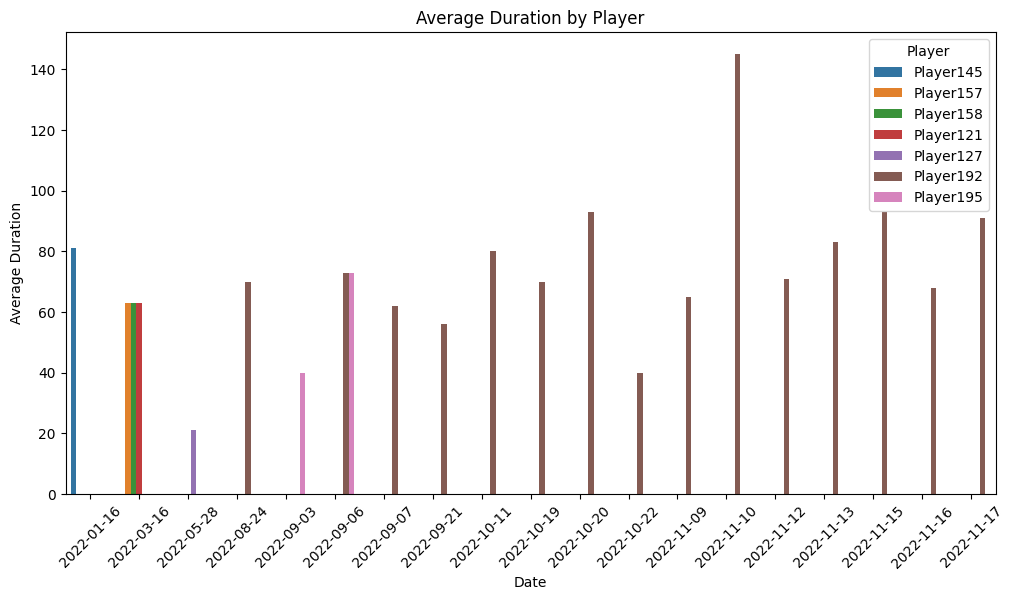

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




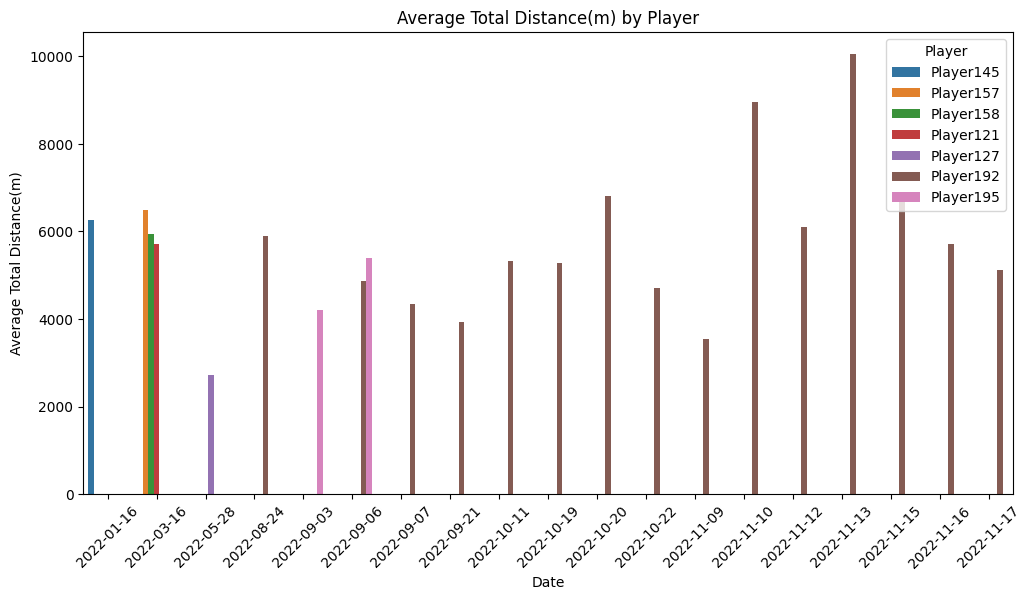

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




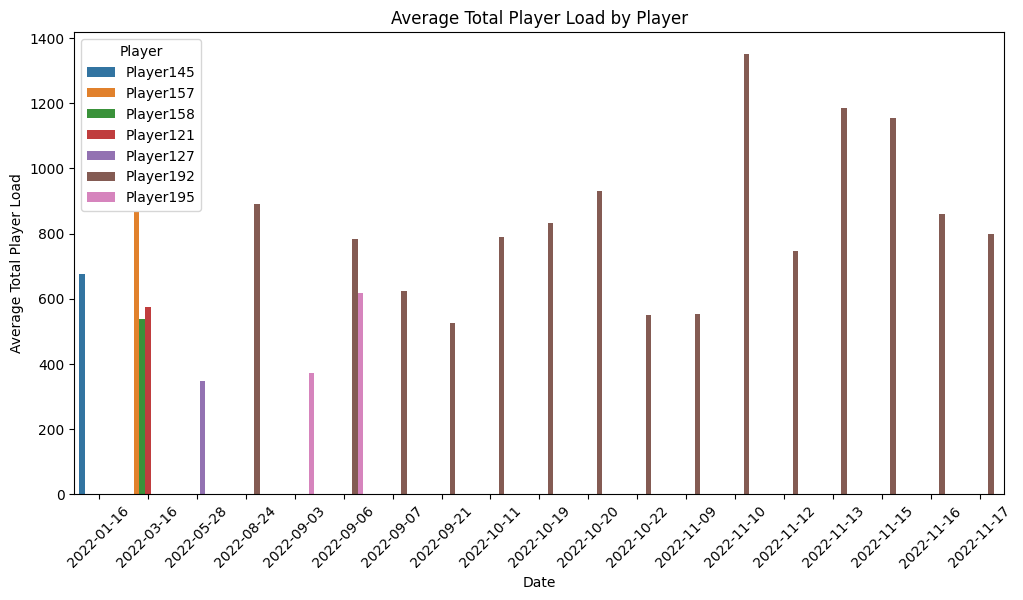

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




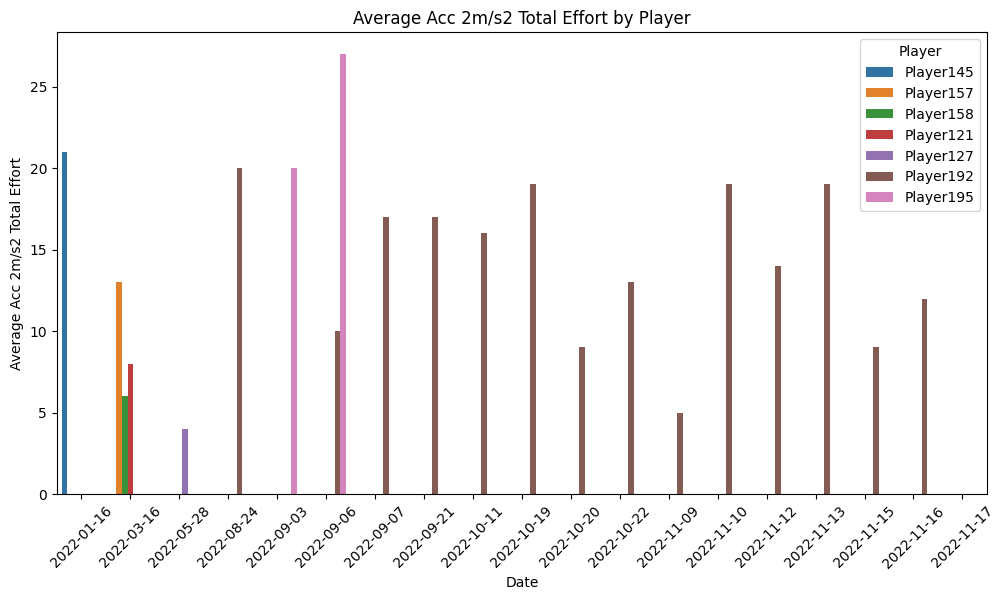

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




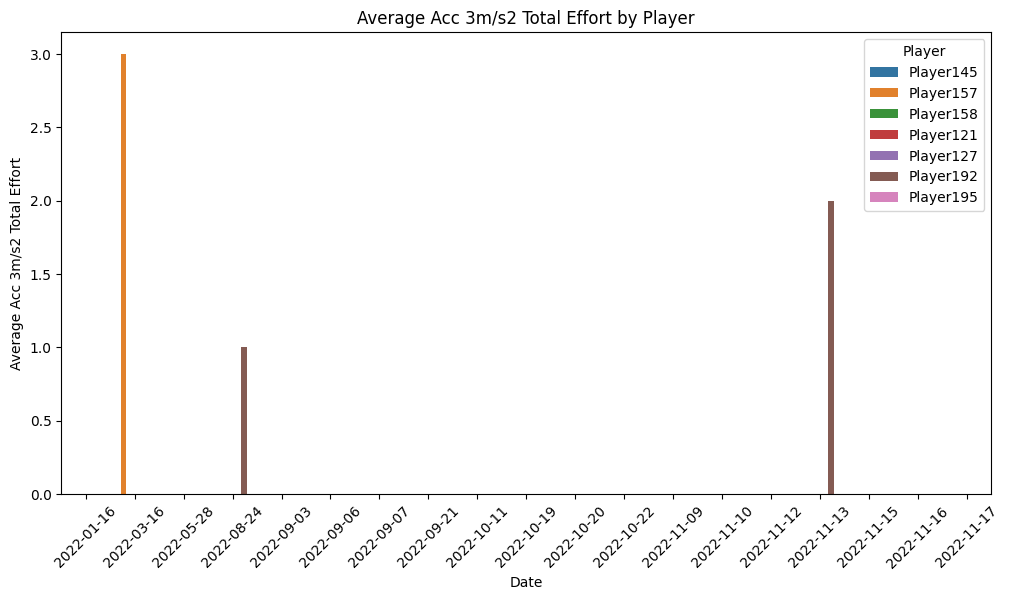

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




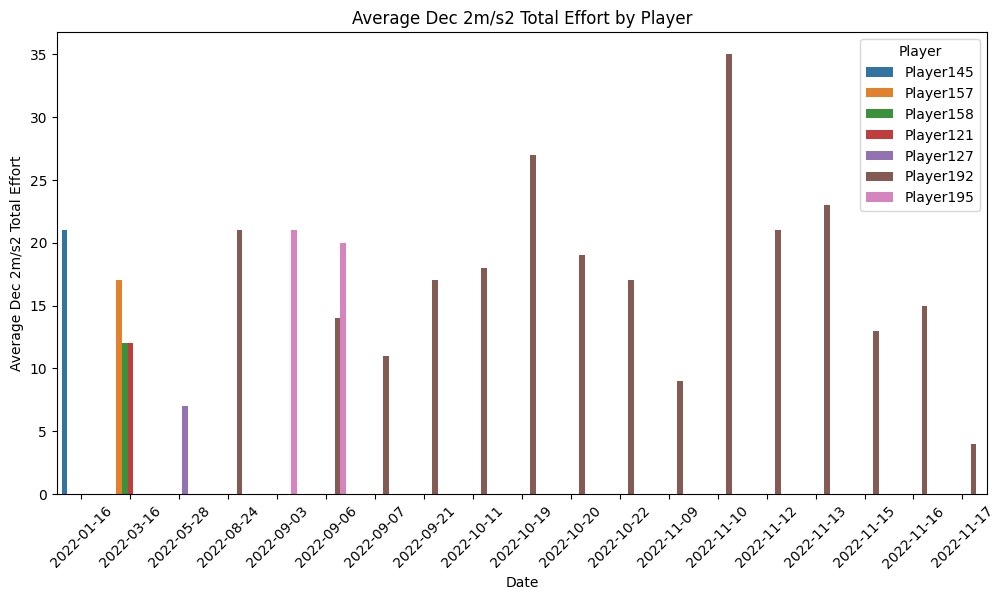

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




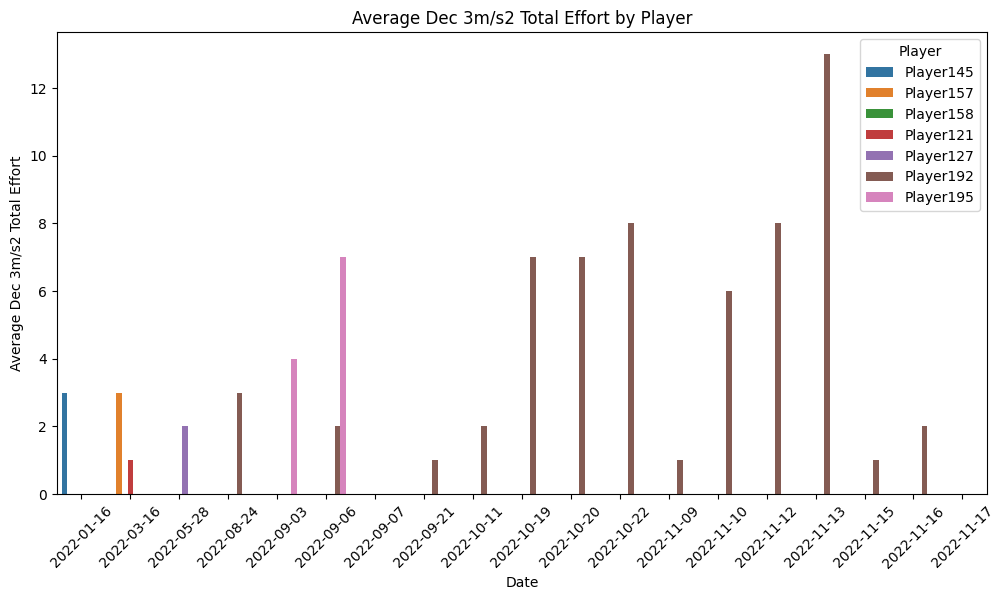

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




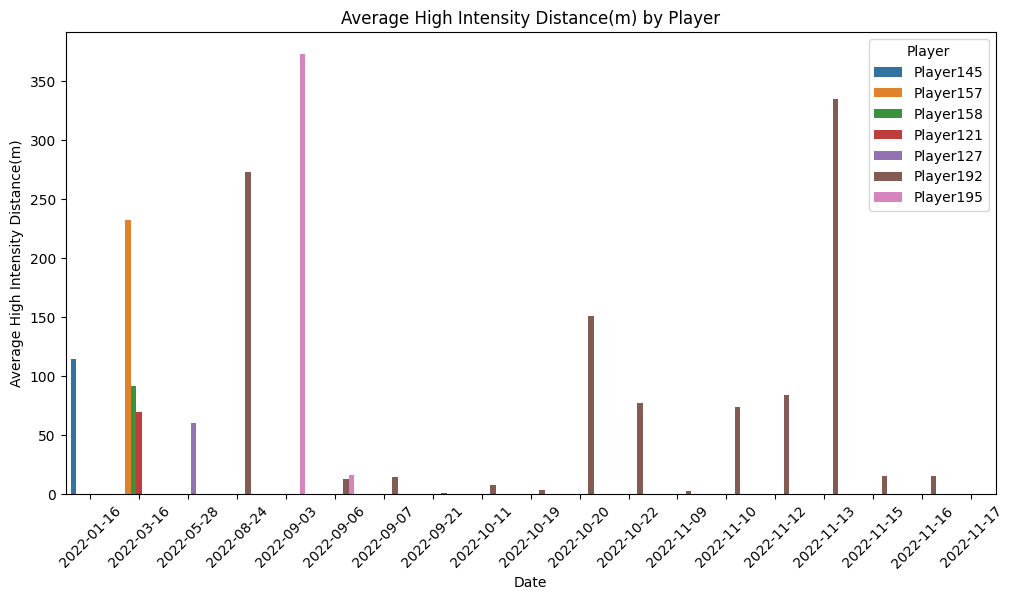

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




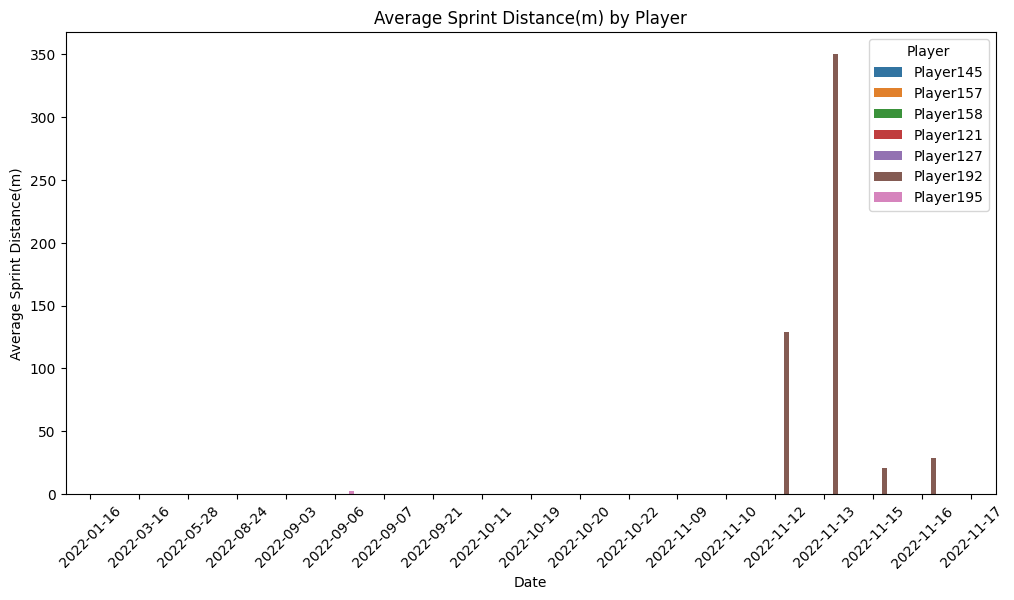

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




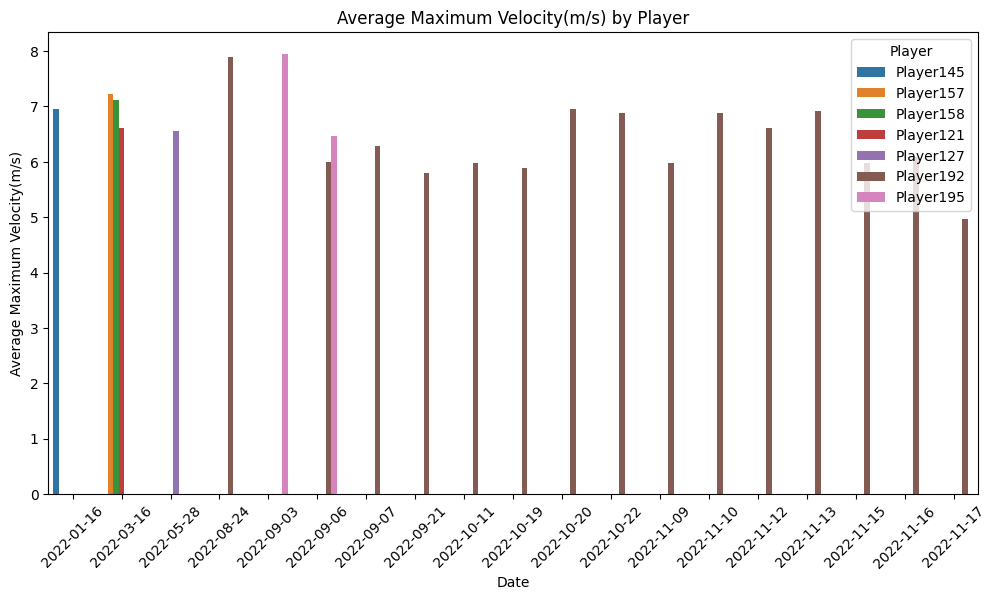

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




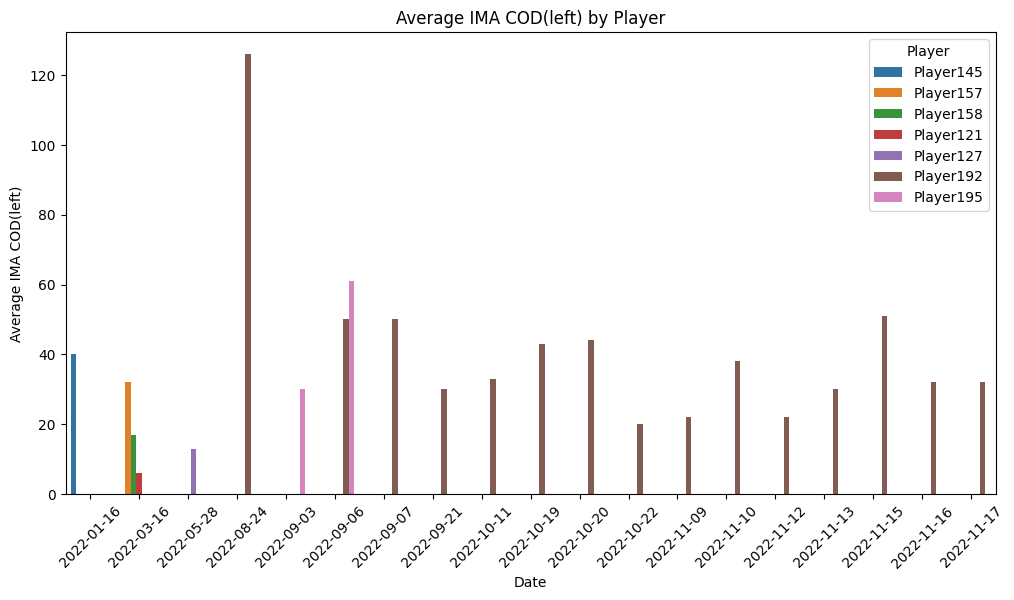

/var/folders/1_/ygw698t54q1fgjfvb_x00lwc0000gn/T/ipykernel_99417/3075590584.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




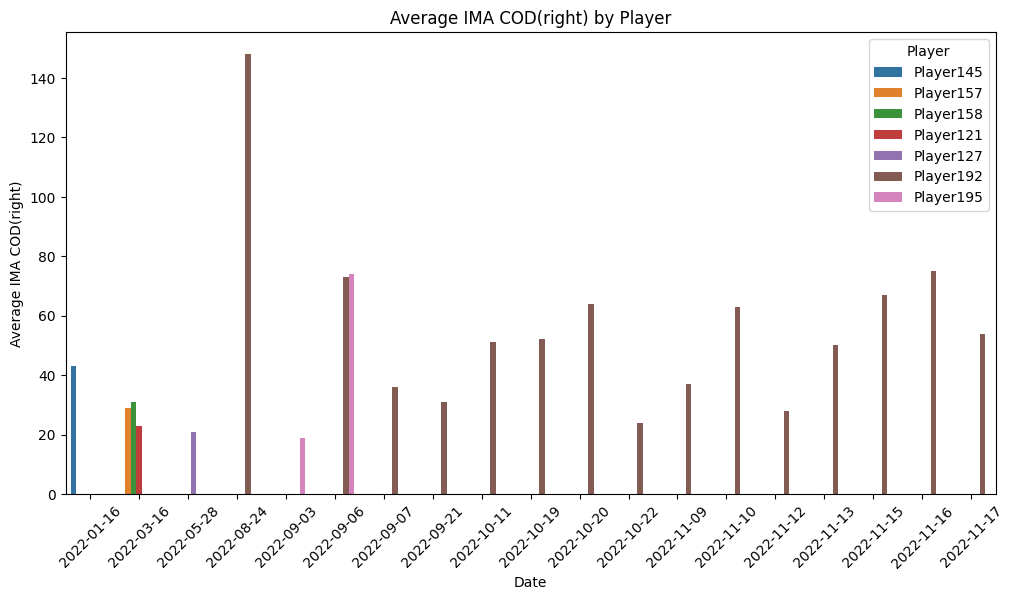

In [44]:
# Function to plot distributions
def plot_metric_by_player(df, metric):
    df = df.sort_values(by='Date')
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Date', y=metric, hue="Player", data=df, ci=None)
    plt.title(f'Average {metric} by Player')
    plt.xlabel('Date')
    plt.ylabel(f'Average {metric}')
    plt.legend(title='Player')
    plt.xticks(rotation=45)
    plt.show()

# Plot average for each metric
for metric in metrics:
    plot_metric_by_player(team8, metric)